In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
%matplotlib inline

from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.cross_validation import train_test_split
from scipy.ndimage.measurements import label

/Users/shuang/anaconda/envs/carnd-term1/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from helper import *

## Load dataset

In [52]:
# Read in cars and notcars
cars = glob.glob('vehicles/**/*.png', recursive=True)
notcars = glob.glob('non-vehicles/**/*.png', recursive=True)

In [53]:
print("Training dataset contains {} car images and {} non-car images.".format(len(cars), len(notcars)))

Training dataset contains 0 car images and 0 non-car images.


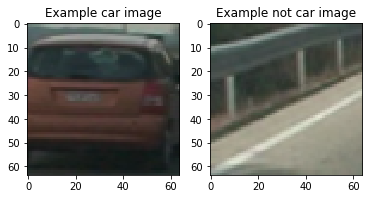

In [6]:
f, axes = plt.subplots(1, 2)
image_car = mpimg.imread(cars[3])
axes[0].imshow(image_car)
axes[0].set_title('Example car image')
image_noncar = mpimg.imread(notcars[4])
axes[1].imshow(image_noncar)
axes[1].set_title('Example not car image')

In [7]:
image_car.shape

(64, 64, 3)

## Generate features

### Color Histogram

In [217]:
image_car = mpimg.imread(cars[90])
feature_image = convert_color(image_car, 'RGB', 'HLS')
bin_centers, hist_features = color_hist(feature_image, nbins=32, bins_range=(0,1))
print('Color Histogram of a Sample Car Image')
f, axes = plt.subplots(1, 4, figsize=(12, 3))
axes[0].imshow(image_car)
axes[1].bar(bin_centers, hist_features[:32], 0.01)
axes[1].set_xlim(0, 1)
axes[1].set_title('Channel1 Histogram')
axes[2].bar(bin_centers, hist_features[32:64], 0.01)
axes[2].set_xlim(0, 1)
axes[2].set_title('Channel2 Histogram')
axes[3].bar(bin_centers, hist_features[64:], 0.01)
axes[3].set_xlim(0, 1)
axes[3].set_title('Channel3 Histogram')
plt.show()

IndexError: list index out of range

Color Histogram of a Sample Non-Car Image


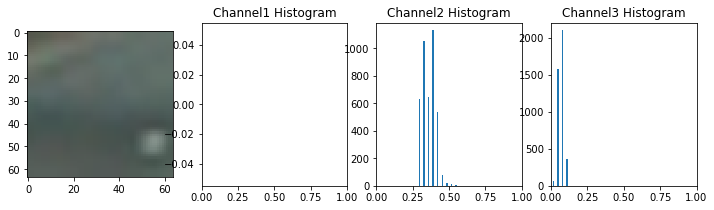

In [9]:
image_noncar = mpimg.imread(notcars[300])
feature_image = convert_color(image_noncar, 'RGB', 'HLS')
bin_centers, hist_features = color_hist(feature_image, nbins=32, bins_range=(0,1))
print('Color Histogram of a Sample Non-Car Image')
f, axes = plt.subplots(1, 4, figsize=(12, 3))
axes[0].imshow(image_noncar)
axes[1].bar(bin_centers, hist_features[:32], 0.01)
axes[1].set_xlim(0, 1)
axes[1].set_title('Channel1 Histogram')
axes[2].bar(bin_centers, hist_features[32:64], 0.01)
axes[2].set_xlim(0, 1)
axes[2].set_title('Channel2 Histogram')
axes[3].bar(bin_centers, hist_features[64:], 0.01)
axes[3].set_xlim(0, 1)
axes[3].set_title('Channel3 Histogram')
plt.show()

### Spatially binned color

In [10]:
feature_image = convert_color(image_car, 'RGB', 'HLS')
car_spatial_features = bin_spatial(feature_image)
feature_image = convert_color(image_noncar, 'RGB', 'HLS')
noncar_spatial_features = bin_spatial(feature_image)

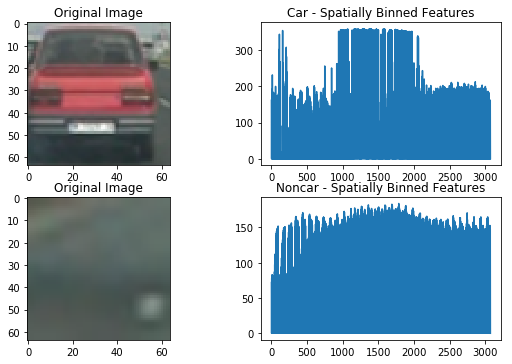

In [11]:
f, axes = plt.subplots(2, 2, figsize=(8, 5))
f.tight_layout()
axes[0][0].imshow(image_car)
axes[0][0].set_title('Original Image')
axes[0][1].plot(car_spatial_features)
axes[0][1].set_title('Car - Spatially Binned Features')
axes[1][0].imshow(image_noncar)
axes[1][0].set_title('Original Image')
axes[1][1].plot(noncar_spatial_features)
axes[1][1].set_title('Noncar - Spatially Binned Features')

### HOG features

In [12]:
gray = cv2.cvtColor(image_car, cv2.COLOR_RGB2GRAY)
hog_features, hog_image = get_hog_features(gray, orient=9, pix_per_cell=8, cell_per_block=2, 
                        vis=True, feature_vec=True)

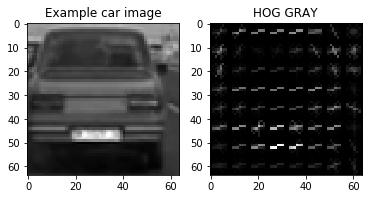

In [13]:
f, axes = plt.subplots(1, 2)
axes[0].imshow(gray, cmap='gray')
axes[0].set_title('Example car image')
axes[1].imshow(hog_image, cmap='gray')
axes[1].set_title('HOG GRAY')

In [14]:
gray = cv2.cvtColor(image_noncar, cv2.COLOR_RGB2GRAY)
hog_features, hog_image = get_hog_features(gray, orient=9, pix_per_cell=8, cell_per_block=2, 
                        vis=True, feature_vec=True)

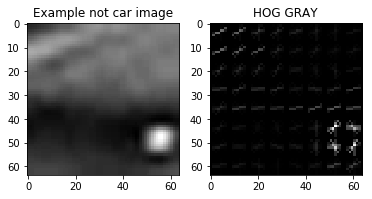

In [15]:
f, axes = plt.subplots(1, 2)
axes[0].imshow(gray, cmap='gray')
axes[0].set_title('Example not car image')
axes[1].imshow(hog_image, cmap='gray')
axes[1].set_title('HOG GRAY')

## Combine Features

In [12]:
### TODO: Tweak these parameters and see how the results change.
parameters = {'color_space':'YCrCb', # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
              'orient':9, # HOG orientations
              'pix_per_cell':8,# HOG pixels per cell
              'cell_per_block':2, # HOG cells per block
              'hog_channel': 'ALL',# Can be 0, 1, 2, or "ALL"
              'spatial_size': (16, 16), # Spatial binning dimensions
              'hist_bins': 32, # Number of histogram bins
              'spatial_feat': True, # Spatial features on or off
              'hist_feat': True, # Histogram features on or off
              'hog_feat': True} # HOG features on or off

In [18]:
car_features = extract_features(cars, **parameters)
notcar_features = extract_features(notcars, **parameters)

In [19]:
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0)
    
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to X
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

print('Using:',parameters['orient'],'orientations',parameters['pix_per_cell'],
    'pixels per cell and', parameters['cell_per_block'],'cells per block')
print('Feature vector length:', len(X_train[0]))

Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 6156


## Train classifier

In [20]:
# Use a linear SVC 
svc = LinearSVC(C=2)
# Check the training time for the SVC
tic=time.time()
svc.fit(X_train, y_train)
toc = time.time()
print(round(toc-tic, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
print('My SVC predicts: ', svc.predict(X_test[0:10]))
print('For labels:      ', y_test[0:10])

18.69 Seconds to train SVC...
Test Accuracy of SVC =  0.9904
My SVC predicts:  [ 1.  1.  0.  1.  1.  0.  1.  0.  1.  1.]
For labels:       [ 1.  1.  0.  1.  1.  0.  1.  0.  1.  1.]


## Slide window search

In [21]:
image = mpimg.imread('test_images/test5.jpg')
draw_image = np.copy(image)

# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
image = image.astype(np.float32)/255
xy_windows =  [(96,96), (128,128)] 
y_start_stops = [[400, 600], [400, None]]
windows_all = []
for xy_window, y_start_stop in zip(xy_windows, y_start_stops):
    windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                        xy_window=xy_window, xy_overlap=(0.5, 0.5))
    windows_all.extend(windows) 

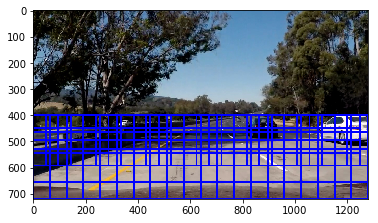

In [22]:
window_img = draw_boxes(draw_image, windows_all, color=(0, 0, 255), thick=6)                    

plt.imshow(window_img)

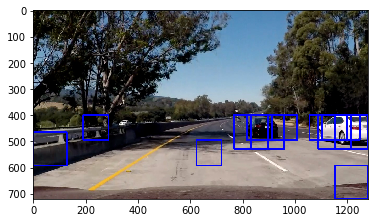

In [23]:
hot_windows = search_windows(image, windows_all, svc, X_scaler, **parameters)                       

window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

plt.imshow(window_img)

## Use Heatmap to remove false positive

In [24]:
heat = np.zeros_like(image[:,:,0]).astype(np.float)
# Add heat to each box in box list
heat = add_heat(heat,hot_windows)  
# Apply threshold to help remove false positives
heat = apply_threshold(heat,1)
# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)
# Find final boxes from heatmap using label function
labels = label(heatmap)
labeled_img = draw_labeled_bboxes(draw_image, labels)

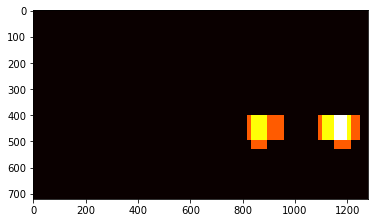

In [25]:
plt.imshow(heatmap, cmap='hot')

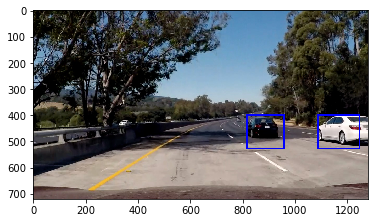

In [26]:
plt.imshow(labeled_img)

In [4]:
import pickle

In [45]:
with open(r"classifier.p", "wb") as output_file:
    pickle.dump(svc, output_file)

In [46]:
with open(r"scaler.p", "wb") as output_file:
    pickle.dump(X_scaler, output_file)

In [6]:
with open(r"classifier.p", "rb") as in_file:
    svc = pickle.load(in_file)

/Users/shuang/anaconda/envs/carnd-term1/lib/python3.5/site-packages/sklearn/base.py:311: UserWarning: Trying to unpickle estimator LinearSVC from version 0.18.1 when using version 0.19.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [10]:
with open(r"scaler.p", "rb") as in_file:
    X_scaler = pickle.load(in_file)

/Users/shuang/anaconda/envs/carnd-term1/lib/python3.5/site-packages/sklearn/base.py:311: UserWarning: Trying to unpickle estimator StandardScaler from version 0.18.1 when using version 0.19.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


## Put together a pipeline

In [13]:
pipeline_parameters = dict(parameters, **{'scaler': X_scaler,'clf': svc})

In [80]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(image, ystart, ystop, scale, clf, scaler, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    bboxes=[]
    draw_img = np.copy(image)
    image = image.astype(np.float32)/255
    
    img_tosearch = image[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv_from='RGB', conv_to=color_space)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    
    # Compute individual channel HOG features for the entire image
    if hog_feat == True:
        hog_features_all = []
    # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':           
            for channel in range(ctrans_tosearch.shape[2]):
                hog_features_all.append(get_hog_features(ctrans_tosearch[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=False))      
        else:
            hog_features_all.append(get_hog_features(ctrans_tosearch[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=False))
    # fix window size to 64, use scale to adjust the image size, this is equivelant to change window size.        
    windows = slide_window(ctrans_tosearch, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.75, 0.75))
    nblocks_per_window = (64 // pix_per_cell) - cell_per_block + 1
    for window in windows:
        # Extract the image patch
        subimg = ctrans_tosearch[window[0][1]:window[1][1], window[0][0]:window[1][0]]
        subimg_features=[]
        if spatial_feat==True:
        # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            subimg_features.append(spatial_features)
#             print(spatial_features.shape)
        if hist_feat==True:
            _, hist_features = color_hist(subimg, nbins=hist_bins)
            subimg_features.append(hist_features)
#             print(hist_features.shape)
        
        # Extract HOG for this patch
        if hog_feat == True:
            hog_features=[]
        # Call get_hog_features() with vis=False, feature_vec=True
            for hog_channel in hog_features_all:
                hog_features.append(hog_channel[window[0][1]//pix_per_cell:window[0][1]//pix_per_cell+nblocks_per_window,  window[0][0]//pix_per_cell:window[0][0]//pix_per_cell+nblocks_per_window].ravel()) 
#                 print(window[0][1]//pix_per_cell,window[0][1]//pix_per_cell+nblocks_per_window,  window[0][0]//pix_per_cell,window[0][0]//pix_per_cell+nblocks_per_window)
            hog_features = np.ravel(hog_features)    
            subimg_features.append(hog_features)
#             print(hog_features.shape)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack(subimg_features).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = clf.predict(test_features)
            
            if test_prediction == 1:
                bboxes.append(((np.int(window[0][0]*scale), np.int(window[0][1]*scale)+ystart),(np.int(window[1][0]*scale),np.int(window[1][1]*scale)+ystart)))
                
    return bboxes

In [81]:
image = mpimg.imread('test_images/test5.jpg')
draw_image = np.copy(image)

In [82]:
bboxes = find_cars(image, 384, 600, 1.5, **pipeline_parameters)

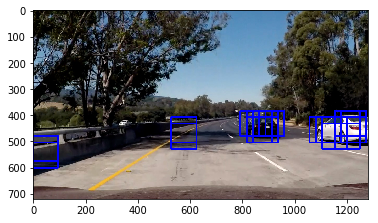

In [83]:
window_img = draw_boxes(draw_image, bboxes, color=(0, 0, 255), thick=6)                    

plt.imshow(window_img)

In [84]:
heat = np.zeros_like(image[:,:,0]).astype(np.float)
heat = add_heat(heat,bboxes)  
heat = apply_threshold(heat,2)  
heatmap = np.clip(heat, 0, 255)
labels = label(heatmap)
labeled_img = draw_labeled_bboxes(draw_image, labels)

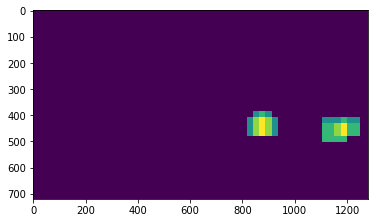

In [85]:
plt.imshow(heatmap)

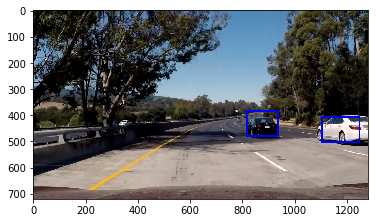

In [86]:
plt.imshow(labeled_img)

In [204]:
pipeline_parameters

{'cell_per_block': 2,
 'clf': LinearSVC(C=2, class_weight=None, dual=True, fit_intercept=True,
      intercept_scaling=1, loss='squared_hinge', max_iter=1000,
      multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
      verbose=0),
 'color_space': 'YCrCb',
 'hist_bins': 32,
 'hist_feat': True,
 'hog_channel': 'ALL',
 'hog_feat': True,
 'orient': 9,
 'pix_per_cell': 8,
 'scaler': StandardScaler(copy=True, with_mean=True, with_std=True),
 'spatial_feat': True,
 'spatial_size': (16, 16)}

In [218]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def process_image(image, n_threshold, **kwargs):
    global hot_windows_list
    draw_image = np.copy(image)
    
#     small_boxes = find_cars(image, 384, 480, 1, **pipeline_parameters) 
    small_boxes = []
    middle_boxes = find_cars(image, 400, 550, 1.5, **pipeline_parameters)
    big_boxes = find_cars(image, 430, 680, 2, **pipeline_parameters)
    hot_windows_list.append(small_boxes + middle_boxes + big_boxes)
    if len(hot_windows_list) > 15:
        hot_windows_list.pop(0)
    
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    for hot_windows in hot_windows_list:
        heat = add_heat(heat, hot_windows)
    
    heat = apply_threshold(heat, n_threshold)
 
    heatmap = np.clip(heat, 0, 255)

    labels = label(heatmap)
    labeled_img = draw_labeled_bboxes(draw_image, labels)    
    
    return labeled_img

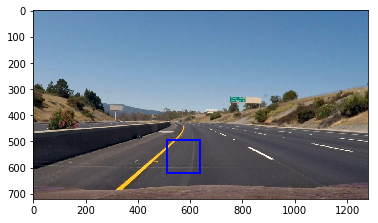

In [220]:
image = mpimg.imread('test_images/project1.jpg')
hot_windows_list=[]
result = process_image(image, n_threshold=3, **pipeline_parameters)
plt.imshow(result)

In [221]:
from functools import partial

In [222]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

hot_windows_list=[]
video = VideoFileClip("project_video.mp4").subclip(0,5)

project_clip = video.fl_image(partial(process_image, n_threshold=20, **pipeline_parameters))

output = "vehicle_detection.mp4"
%time project_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video vehicle_detection.mp4
[MoviePy] Writing video vehicle_detection.mp4


 99%|█████████▉| 125/126 [00:57<00:00,  2.24it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: vehicle_detection.mp4 

CPU times: user 56.6 s, sys: 1.53 s, total: 58.1 s
Wall time: 58.2 s


In [197]:
video = VideoFileClip("project_video.mp4")#.subclip(0,5)
for i in range(0, 100, 2):
    video.save_frame('test_images/project{}.jpg'.format(str(i+1)), t=i)